# EDA: Transaction Fraud Dataset
В этом ноутбуке **только** EDA: загрузка, нормализация сумм в USD, распаковка вложенных полей, базовые срезы.


In [2]:
import sys
from pathlib import Path
ROOT = Path().resolve()
if not (ROOT/'src').exists(): ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))
print('Project root:', ROOT)


Project root: /Users/gumerovbr/Documents/GitHub/data_analysis_itmo_2025


In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from src.data import load_transactions, load_fx
from src.currency import convert_to_usd
from src.features import unpack_last_hour_activity, add_basic_time_features

DATA=Path('../data'); TX=DATA/'transaction_fraud_data.parquet'; FX=DATA/'historical_currency_exchange.parquet'

df = load_transactions(TX)
fx = load_fx(FX)
df = convert_to_usd(df, fx)
df = unpack_last_hour_activity(df)
df = add_basic_time_features(df)
df.head()


,transaction_id,customer_id,card_number,timestamp,vendor_category,vendor_type,vendor,amount,currency,country,...,rate_to_currency,amount_usd,last_hour_activity__num_transactions,last_hour_activity__total_amount,last_hour_activity__unique_merchants,last_hour_activity__unique_countries,last_hour_activity__max_single_amount,tx_hour,tx_dow,tx_month
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,0.747153,394.658011,1197,3.349856e+07,105,12,1.925481e+06,0,0,9
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,5.434649,619.905757,509,2.011476e+07,100,12,5.149117e+06,0,0,9
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,142.573268,719.506409,332,3.916385e+07,97,12,1.852242e+06,0,0,9
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466,Gas,major,Exxon,630.60,AUD,Australia,...,1.443654,436.808287,764,2.201260e+07,105,12,2.055798e+06,0,0,9
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,1668.736400,434.430069,218,4.827636e+06,88,12,1.157231e+06,0,0,9


## 1. Информация и пропуски

### Что здесь делаем
* Проверяем типы колонок, наличие вложенных структур и распределение пропусков.
* Валидируем временные поля (timestamp) и ожидаемые домены категориальных полей.

### На что обратить внимание
* Атипичные типы (например, timestamp как строка).
* Высокая доля NaN в критичных признаках (например, amount, currency, флаги риска).
* Возможные дубликаты transaction_id.


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7483766 entries, 0 to 7483765
Data columns (total 33 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   transaction_id                         object        
 1   customer_id                            object        
 2   card_number                            int64         
 3   timestamp                              datetime64[us]
 4   vendor_category                        object        
 5   vendor_type                            object        
 6   vendor                                 object        
 7   amount                                 float64       
 8   currency                               object        
 9   country                                object        
 10  city                                   object        
 11  city_size                              object        
 12  card_type                              object        
 1

In [6]:
df.isna().mean().sort_values(ascending=False).head(20)

transaction_id                           0.0
ip_address                               0.0
tx_dow                                   0.0
tx_hour                                  0.0
last_hour_activity__max_single_amount    0.0
last_hour_activity__unique_countries     0.0
last_hour_activity__unique_merchants     0.0
last_hour_activity__total_amount         0.0
last_hour_activity__num_transactions     0.0
amount_usd                               0.0
rate_to_currency                         0.0
date                                     0.0
is_fraud                                 0.0
is_weekend                               0.0
is_high_risk_vendor                      0.0
is_outside_home_country                  0.0
device_fingerprint                       0.0
customer_id                              0.0
channel                                  0.0
device                                   0.0
dtype: float64

Пропусков в данных не обнаружено

## 2. Баланс классов

### Что здесь делаем
* Оцениваем общий уровень дисбаланса классов (fraud rate).

### Почему это важно
* При сильном дисбалансе основная метрика — PR-AUC; ROC-AUC менее чувствительна.
* Дисбаланс влияет на выбор стратегии валидации и пороговой политики (Precision-ориентированная).

In [ ]:
print(f"N={len(df):,}"); print('fraud_rate=', df['is_fraud'].mean())


N=7,483,766
fraud_rate= 0.19972818498066347


### Выводы по балансу классов

**Факты**
- Объем данных: **7 483 766** транзакций.
- Доля мошенничества (**fraud_rate**): **19.97%** (≈ **1.49 млн** fraud vs **≈ 5.99 млн** legit).
- Соотношение классов (legit:fraud) ≈ **4 : 1** — умеренный дисбаланс, не экстремальный.

**Последствия для метрик и валидации**
- Базовый уровень **PR-AUC** случайного классификатора равен доле позитивов, т.е. ~**0.20**; улучшения PR-AUC следует сравнивать именно с этим порогом.
- **ROC-AUC** при таком дисбалансе может выглядеть «прилично», но бизнес-смысл отражает **PR-кривая** (Precision/Recall) — используем **PR-AUC** как основную метрику.
- Для подбора порогов ориентируемся на **Precision ≥ 0.90** с мониторингом **Recall** и доли трафика, попадающего в step-up/ручную проверку.

**Рекомендации к моделированию**
- Умеренный дисбаланс позволяет избежать агрессивного oversampling/SMOTE; достаточно **class_weight='balanced'** или cost-sensitive подхода.
- Разбиение — **time-based split** (без shuffle) для избежания утечки во времени.
- Отдельно отслеживать метрики по ключевым сегментам (CNP, cross-border, high-risk vendor), т.к. при такой доле fraud нагрузка на фрикцию/ручную проверку может быстро расти при слишком низких порогах.

## 3. Распределения сумм (USD)

### Что здесь делаем
* Смотрим распределение amount_usd после нормализации и грубые прокси скорости из last_hour_activity.* (корреляция с is_fraud).

### Почему это важно
* Экстремальные хвосты могут «таскать» модель; полезно будет каппинг/лог-преобразование.
* Velocity-сигналы часто являются сильными предикторами мошенничества.

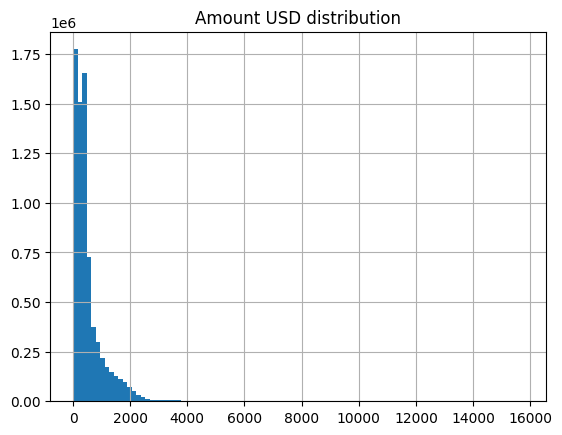

In [ ]:
df['amount_usd'].dropna().hist(bins=100); plt.title('Amount USD distribution'); plt.show()


### Выводы по распределениям сумм (USD)

**Наблюдения**
- Распределение **сильно правостороннее (heavy-tail)**: подавляющее большинство транзакций — на малые суммы, но присутствует длинный хвост вплоть до крупных значений.
- Видны локальные скопления на «круглых» величинах (ценовые якоря), что типично для ритейла/онлайна.
- При такой форме распределения линейные модели и неустойчивые пороги по «сырым» суммам склонны к **нестабильности** и чувствительны к редким экстремумам.

**Риски качества/обработки**
- Хвостовые значения способны «перетягивать» обучение; без нормализации модель будет недооценивать слабые, но массовые паттерны.

**Рекомендации по препроцессингу (для последующих экспериментов)**
1. **Лог-преобразование**: использовать `log1p(amount_usd)` в моделях.
2. **Каппинг хвостов**: winsorization на уровне **P99–P99.5** по `amount_usd` (проверить на валидации устойчивость PR-AUC).
3. **Относительные признаки**: 
   - отношение суммы к «типичной» трате клиента/карты/устройства (медиана ± MAD за историю);
   - отклонение от медианы в Z/MAD-скоринге.
4. **Сегментные квантили** (для пороговой политики): хранить **P80/P90/P95** `amount_usd` среди **legit** отдельно для CNP, cross-border, high-risk vendor — пригодится для step-up/ручной проверки.
5. **Проверки данных**:
   - наличие/доля отрицательных сумм (refund/chargeback) и единая политика их обработки (фильтр или отдельный флаг).

**Следующие шаги**
- Зафиксировать набор квантилей (`P50/P90/P95/P99`) по `amount_usd` в отчёте EDA и использовать их в H2/H3 при настройке сегментных порогов.
- Провести A/B на моделях: сырая сумма vs `log1p` + каппинг → сравнить **PR-AUC** и **Recall@Precision≥0.90** на time-split.

## 4. Fraud rate по категориям

### Что здесь делаем
* Считаем уровень мошенничества по ключевым категориям (вендор, канал, устройство и т.д.).

### Почему это важно
* Раннее выявление «токсичных» категорий позволяет настраивать сегментные пороги и правила.
* Высокая кардинальность (например, vendor) требует аккуратного кодирования (target/WOE, hashing) без утечек.

### Замечание
* Для корректности полезно вводить минимальный порог по размеру группы (например, ≥200 наблюдений), чтобы не реагировать на шум в редких категориях.

In [8]:
def fr_by(col):
    g = df.groupby(col)['is_fraud'].mean().sort_values(ascending=False)
    return g.to_frame('fraud_rate').head(20)
fr_by('vendor_category').head(20)


,fraud_rate
vendor_category,
Travel,0.200341
Grocery,0.200194
Gas,0.199731
Restaurant,0.199696
Entertainment,0.199632
Education,0.199459
Retail,0.199398
Healthcare,0.199376


### Выводы по FR в разрезе `vendor_category`

**Наблюдения**
- Значения FR по категориям практически не отличаются от общего уровня (**~0.1997**):  
  `Travel ≈ 0.20034`, `Grocery ≈ 0.20019`, `Gas ≈ 0.19973`, `Restaurant ≈ 0.19970`, `Entertainment ≈ 0.19963`, `Education ≈ 0.19946`, `Retail ≈ 0.19940`, `Healthcare ≈ 0.19938`.
- Абсолютные различия — на сотые доли процента (±0.0006), что **не даёт явного сигнала** для категорных правил на верхнем уровне таксономии.

**Интерпретация**
- Одна лишь «грубая» категория вендора, вероятно, **не является сильным предиктором** — полезный сигнал раскрывается на более тонких разрезах и в **взаимодействиях** с другими факторами (CNP, cross-border, устройство/канал, время).
- Возможен эффект Симпсона: при агрегации по крупным классам различия сглаживаются.

**Рекомендации**
1. Перейти к более детальной гранулярности: `vendor_type`, `channel`, `device`, а также флаги `is_card_present`, `is_outside_home_country`, `is_high_risk_vendor`.
2. Анализировать **lift** относительно глобального FR: `lift = FR(cat) / FR(global)` и учитывать объём категории (volume-weighted lift).
3. Добавить **взаимодействия** (например, `vendor_category × is_card_present`, `vendor_category × cross_border`) — часто дают заметный прирост.
4. Для high-cardinality признаков (`vendor`) использовать **fold-wise target encoding / WOE** с контролем утечки; для редких значений — сглаживание/бининги.
5. Проверить статистическую значимость отличий через доверительные интервалы (Wilson 95% CI) по каждой категории; если CI перекрывает глобальный FR — различие можно считать нерелевантным для правил.

**Практический вывод**
- Не вводить «жёсткие» пороги только по `vendor_category`. Горизонт ценности — **сегментные пороги** и модельные фичи, учитывающие комбинации факторов.

## 5. Временные паттерны

### Что здесь делаем
* Анализируем вариативность fraud rate по часу суток и дню недели.

### Почему это важно
* Временная фрикция (понижение/повышение порогов в «рискованные» часы/дни) даёт экономию при стабильной точности.

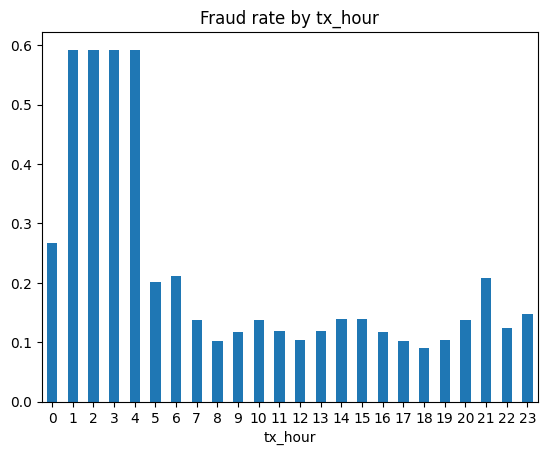

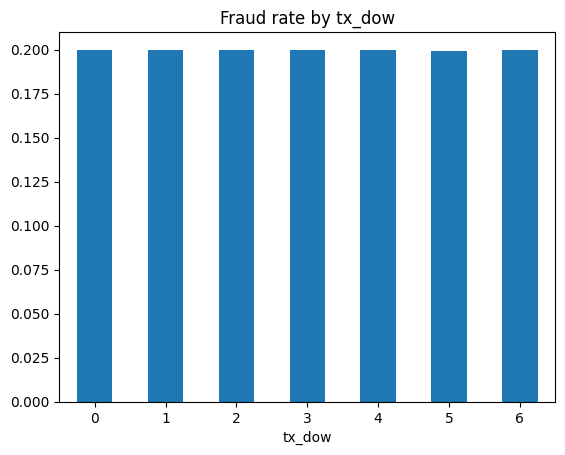

In [ ]:
for col in ['tx_hour','tx_dow']:
    df.groupby(col)['is_fraud'].mean().plot(kind='bar', rot=0); plt.title(f'Fraud rate by {col}'); plt.show()


### Выводы по временным паттернам

**Наблюдения**
- По **часам суток** виден ярко выраженный «ночной» риск:
  - **01:00–04:00** — FR ≈ **0.58–0.60** (≈ ×3 к глобальному ~0.20).
  - **00:00** — тоже повышен (≈ **0.27**).
  - Днём/вечером FR в основном в диапазоне **0.10–0.20** с локальными всплесками около **21:00–23:00** (до ≈ **0.21**).
- По **дням недели** различий почти нет: FR ≈ **0.20** равномерно по `tx_dow ∈ [0..6]`.

**Интерпретация**
- Сильный сигнал идёт от **часа суток**, а не от дня недели. Это согласуется с поведенческими паттернами злоумышленников (активность в «тонкие» ночные часы).

**Проверки качества (обязательно перед внедрением)**
- Проверить **объём наблюдений по часам** (min N per hour) и 95% CI (например, Wilson) — чтобы исключить артефакты малых выборок.
- Уточнить **часовой пояс** и консистентность `timestamp` (локальное vs UTC). При необходимости перевести в локальное время клиента/мерчанта.
- Убедиться, что на «ночные» часы не падают системные операции/батчи.

**Рекомендации**
1. **Сегментная политика по времени суток**:
   - В окне **01:00–04:00** — снизить пороги для step-up/ручной проверки на **20–30%** (draft) или повысить требуемую модельную вероятность.
   - Совместить с факторами **CNP**, **cross-border**, **high-risk vendor** (взаимодействия дают наибольшую отдачу).
2. **Модельные фичи**:
   - Добавить one-hot `tx_hour` (или циклическое кодирование) и их взаимодействия с ключевыми флагами риска.
3. **Мониторинг**:
   - Ежечасный дашборд FR и доли фрикции; алёрты на резкие сдвиги ночного FR (дрейф).

**Следующие шаги**
- Пересчитать FR по часам с фильтром `N_hour ≥ 5 000` (или иным бизнес-порогом) и с доверительными интервалами.
- Смоделировать влияние «ночных» порогов на **Recall@Precision≥0.90** и долю трафика в фрикции; зафиксировать итоговые пороги в отчёте.